In [1]:
import json
import os

import tqdm
import datetime
import pytz
import numpy

import pandas

import scipy.stats
import sklearn.svm
import sklearn.ensemble
import math

%matplotlib widget
import matplotlib
import matplotlib.pyplot

import seaborn

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
WR_CONFIDENCE       = 0.50
LIMIT_DATE_SETUP_START  = pytz.utc.localize(datetime.datetime(2023,7,17))
LIMIT_DATE_EXP          = pytz.utc.localize(datetime.datetime(2023,7,29))
LIMIT_DATE_SETUP_STOP   = pytz.utc.localize(datetime.datetime(2023,8,1))
root_path = '/Users/matthieu/.ssh/ssh_to_graz/saved_graz_data/' + source_computer + '/metadata/'
data_path = root_path + '/'
conf_path = root_path + '../config/'

actuation_ratios = pandas.read_pickle(conf_path + 'processed_actuation_phases.pickle')

days_to_discard_str = ['23/07/22', '23/07/25']#, '23/07/20']#, '23/07/24', '23/07/26']
days_to_discard = [pytz.utc.localize(datetime.datetime.strptime(x, '%y/%m/%d')).date() for x in days_to_discard_str]

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
# print(pfiles)

# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]

# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

exp_configs = pandas.DataFrame.from_records(exp_configs).tail(-1) # remove first row --> default configuration

## Effect of the vibrations on the number of waggle runs for the 2 hours experiments : Processing

In [5]:
DURATION_EXPERIMENT_2H = datetime.timedelta(minutes=10.0)
results = []

for exp_i, exp in exp_configs.iterrows():
    # print(exp)
    res = dict(exp)

    if exp['dtts_start'] < LIMIT_DATE_SETUP_START or exp['dtts_start'] > LIMIT_DATE_EXP :
        continue

    if exp['dtts_start'].date() in days_to_discard :
        continue
    
    if exp.rule == 'vibrate':
        res['type'] = 'exp'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT_2H
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H
    elif exp.rule == 'no_vibrate':
        res['type'] = 'blank'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT_2H
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_2H
    

    # Naively take all of the waggles and count them
    ctrl_runs = all_waggles_df[all_waggles_df.timestamp_begin > ctrl_start_time]
    ctrl_runs = ctrl_runs[ctrl_runs.timestamp_begin < ctrl_stop_time]
    vibs_runs = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
    vibs_runs = vibs_runs[vibs_runs.timestamp_begin < vibs_stop_time]

    res['Ncount_ctrl'] = len(ctrl_runs)
    res['Ncount_vibs'] = len(vibs_runs)
    
    # Take only the waggles with high confidence and count them
    ctrl_runs_confidence = ctrl_runs[ctrl_runs.label_confidence > WR_CONFIDENCE]
    vibs_runs_confidence = vibs_runs[vibs_runs.label_confidence > WR_CONFIDENCE]

    res['Ccount_ctrl'] = len(ctrl_runs_confidence)
    res['Ccount_vibs'] = len(vibs_runs_confidence)

    # Compare waggle runs that we want to inhibit with others
    target_angle            = exp.angle_deg
    ctrl_runs_not_targeted  = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) > 90]
    ctrl_runs_targeted      = ctrl_runs_confidence[abs(ctrl_runs_confidence.dance_world_angle_deg%360-target_angle) < 90]
    vibs_runs_not_targeted  = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) > 90]
    vibs_runs_targeted      = vibs_runs_confidence[abs((vibs_runs_confidence.dance_world_angle_deg)%360-target_angle) < 90]

    res['Tcount_ctrl']  = len(ctrl_runs_targeted)
    res['NTcount_ctrl'] = len(ctrl_runs_not_targeted)
    res['Tcount_vibs']  = len(vibs_runs_targeted)
    res['NTcount_vibs'] = len(vibs_runs_not_targeted)

    # if exp_i == 10:
    #     print(target_angle)
    #     print(vibs_runs_targeted.dance_world_angle_deg%360)

    results.append(res)

results_2h             = pandas.DataFrame.from_dict(results)
results_2h['drop_C']   = (results_2h.Ccount_ctrl-results_2h.Ccount_vibs)/results_2h.Ccount_ctrl
results_2h['drop_T']   = (results_2h.Tcount_ctrl-results_2h.Tcount_vibs)/results_2h.Tcount_ctrl
results_2h['drop_NT']  = (results_2h.NTcount_ctrl-results_2h.NTcount_vibs)/results_2h.NTcount_ctrl
results_2h['count_exp']  = range(1, len(results_2h)+1)
results_2h

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ncount_ctrl,Ncount_vibs,Ccount_ctrl,Ccount_vibs,Tcount_ctrl,NTcount_ctrl,Tcount_vibs,NTcount_vibs,drop_C,drop_T,drop_NT,count_exp
0,2023-07-17T09:10:00+02:00,2023-07-17T11:10:00+02:00,no_vibrate,2023-07-17 09:10:00+02:00,2023-07-17 11:10:00+02:00,314.0,blank,1058,744,1046,728,656,390,450,278,0.304015,0.314024,0.287179,1
1,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0,exp,1014,160,998,158,638,360,94,64,0.841683,0.852665,0.822222,2
2,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0,exp,788,268,780,266,438,342,50,216,0.658974,0.885845,0.368421,3
3,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0,exp,214,248,212,246,66,146,92,154,-0.160377,-0.393939,-0.054795,4
4,2023-07-18T11:40:00+02:00,2023-07-18T13:40:00+02:00,no_vibrate,2023-07-18 11:40:00+02:00,2023-07-18 13:40:00+02:00,314.0,blank,246,154,244,154,124,120,86,68,0.368852,0.306452,0.433333,5
5,2023-07-19T10:00:00+02:00,2023-07-19T12:00:00+02:00,no_vibrate,2023-07-19 10:00:00+02:00,2023-07-19 12:00:00+02:00,314.0,blank,1482,1024,1462,1018,466,996,328,690,0.303694,0.296137,0.307229,6
6,2023-07-19T12:10:00+02:00,2023-07-19T14:10:00+02:00,no_vibrate,2023-07-19 12:10:00+02:00,2023-07-19 14:10:00+02:00,314.0,blank,850,620,838,596,404,434,292,304,0.288783,0.277228,0.299539,7
7,2023-07-19T14:20:00+02:00,2023-07-19T16:20:00+02:00,vibrate,2023-07-19 14:20:00+02:00,2023-07-19 16:20:00+02:00,314.0,exp,726,192,702,184,418,284,54,130,0.737892,0.870813,0.542254,8
8,2023-07-20T09:10:00+02:00,2023-07-20T11:10:00+02:00,vibrate,2023-07-20 09:10:00+02:00,2023-07-20 11:10:00+02:00,314.0,exp,186,256,180,248,100,80,186,62,-0.377778,-0.860000,0.225000,9
9,2023-07-20T11:20:00+02:00,2023-07-20T13:20:00+02:00,no_vibrate,2023-07-20 11:20:00+02:00,2023-07-20 13:20:00+02:00,314.0,blank,756,672,738,650,372,366,236,414,0.119241,0.365591,-0.131148,10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


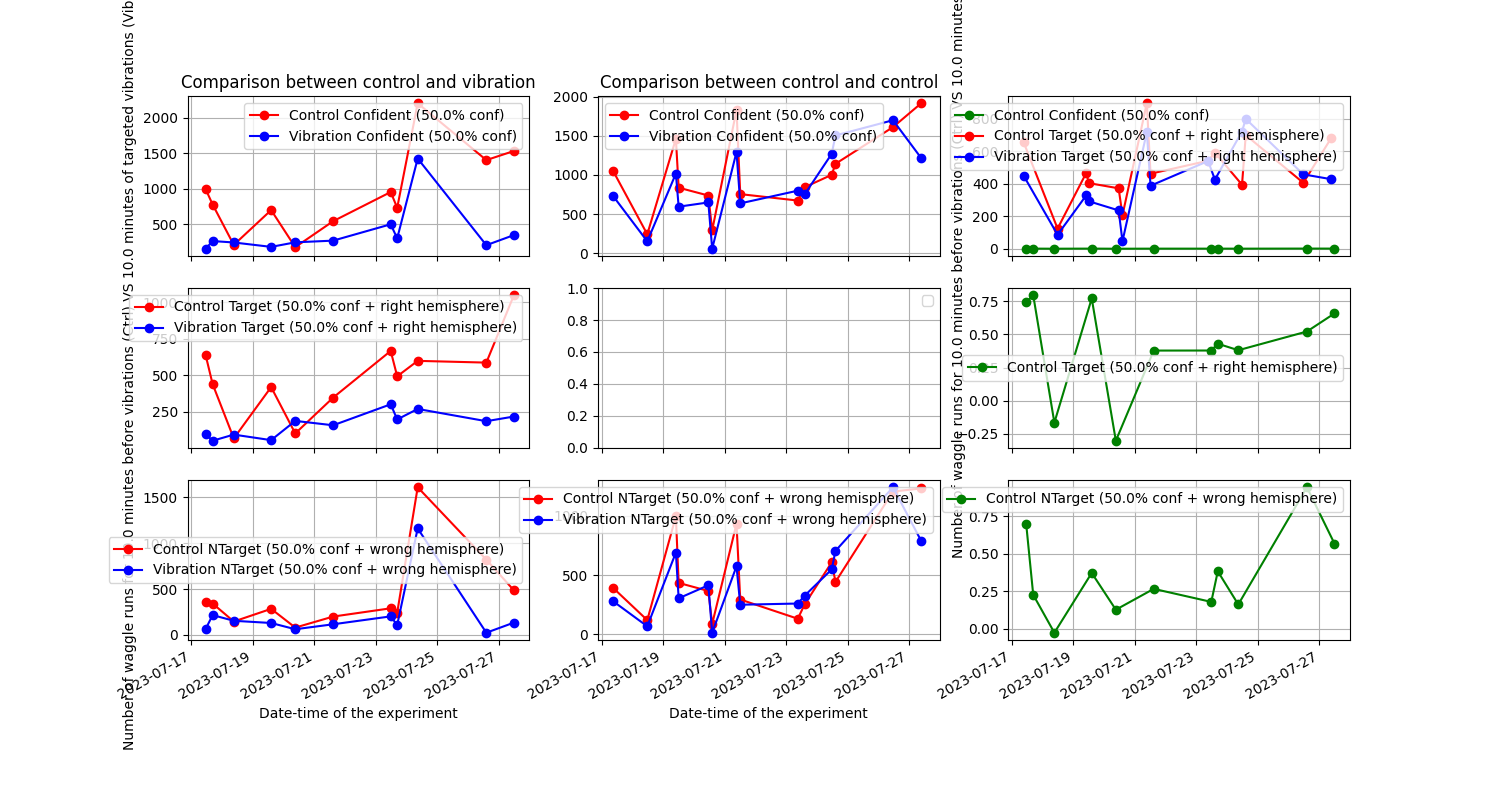

In [6]:
exp_results     = results_2h[results_2h.type == 'exp']
blank_results   = results_2h[results_2h.type == 'blank']

N_plots_h = 3
N_plots_v = 3
fig, ax = matplotlib.pyplot.subplots(N_plots_v, N_plots_h, figsize=(15,8), sharex=True)
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_ctrl, c='r', marker='o', label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,0].plot(exp_results.dtts_start, exp_results.Ccount_vibs, c='b', marker='o',label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_ctrl, c='r', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[1,0].plot(exp_results.dtts_start, exp_results.Tcount_vibs, c='b', marker='o',label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_ctrl, c='r', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_vibs, c='b', marker='o',label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


ax[0,2].plot(exp_results.dtts_start, (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs), c='g', marker='o',label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[1,2].plot(exp_results.dtts_start, (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs), c='g', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,2].plot(exp_results.dtts_start, (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs), c='g', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_ctrl, c='r', marker='o',label='Control Confident ({}% conf)'.format(WR_CONFIDENCE*100))
ax[0,1].plot(blank_results.dtts_start, blank_results.Ccount_vibs, c='b', marker='o',label='Vibration Confident ({}% conf)'.format(WR_CONFIDENCE*100))

ax[0,2].plot(blank_results.dtts_start, blank_results.Tcount_ctrl, c='r', marker='o',label='Control Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))
ax[0,2].plot(blank_results.dtts_start, blank_results.Tcount_vibs, c='b', marker='o',label='Vibration Target ({}% conf + right hemisphere)'.format(WR_CONFIDENCE*100))

ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_ctrl, c='r', marker='o',label='Control NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))
ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_vibs, c='b', marker='o',label='Vibration NTarget ({}% conf + wrong hemisphere)'.format(WR_CONFIDENCE*100))


for i in range(N_plots_v):
    for j in range(N_plots_h):
        ax[i,j].grid()
        ax[i,j].legend()

_ = ax[0,0].set_title('Comparison between control and vibration')
_ = ax[1,0].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60, DURATION_EXPERIMENT_2H.total_seconds()/60))
_ = ax[2,0].set_xlabel('Date-time of the experiment')

_ = ax[0,1].set_title('Comparison between control and control')
_ = ax[0,2].set_ylabel('Number of waggle runs for {} minutes before vibrations (Ctrl) VS {} minutes of targeted vibrations (Vibs)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60, DURATION_EXPERIMENT_2H.total_seconds()/60))
_ = ax[2,1].set_xlabel('Date-time of the experiment')

matplotlib.pyplot.gcf().autofmt_xdate()

In [7]:
exp_results

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ncount_ctrl,Ncount_vibs,Ccount_ctrl,Ccount_vibs,Tcount_ctrl,NTcount_ctrl,Tcount_vibs,NTcount_vibs,drop_C,drop_T,drop_NT,count_exp
1,2023-07-17T11:10:00+02:00,2023-07-17T13:10:00+02:00,vibrate,2023-07-17 11:10:00+02:00,2023-07-17 13:10:00+02:00,314.0,exp,1014,160,998,158,638,360,94,64,0.841683,0.852665,0.822222,2
2,2023-07-17T16:40:00+02:00,2023-07-17T18:40:00+02:00,vibrate,2023-07-17 16:40:00+02:00,2023-07-17 18:40:00+02:00,314.0,exp,788,268,780,266,438,342,50,216,0.658974,0.885845,0.368421,3
3,2023-07-18T09:10:00+02:00,2023-07-18T11:10:00+02:00,vibrate,2023-07-18 09:10:00+02:00,2023-07-18 11:10:00+02:00,314.0,exp,214,248,212,246,66,146,92,154,-0.160377,-0.393939,-0.054795,4
7,2023-07-19T14:20:00+02:00,2023-07-19T16:20:00+02:00,vibrate,2023-07-19 14:20:00+02:00,2023-07-19 16:20:00+02:00,314.0,exp,726,192,702,184,418,284,54,130,0.737892,0.870813,0.542254,8
8,2023-07-20T09:10:00+02:00,2023-07-20T11:10:00+02:00,vibrate,2023-07-20 09:10:00+02:00,2023-07-20 11:10:00+02:00,314.0,exp,186,256,180,248,100,80,186,62,-0.377778,-0.860000,0.225000,9
13,2023-07-21T14:45:00+02:00,2023-07-21T16:45:00+02:00,vibrate,2023-07-21 14:45:00+02:00,2023-07-21 16:45:00+02:00,314.0,exp,552,276,546,272,346,200,156,116,0.501832,0.549133,0.420000,14
15,2023-07-23T11:40:00+02:00,2023-07-23T13:40:00+02:00,vibrate,2023-07-23 11:40:00+02:00,2023-07-23 13:40:00+02:00,314.0,exp,972,522,956,502,666,290,300,202,0.474895,0.549550,0.303448,16
17,2023-07-23T16:45:00+02:00,2023-07-23T18:45:00+02:00,vibrate,2023-07-23 16:45:00+02:00,2023-07-23 18:45:00+02:00,314.0,exp,746,312,734,304,492,242,196,108,0.585831,0.601626,0.553719,18
18,2023-07-24T08:45:00+02:00,2023-07-24T10:45:00+02:00,vibrate,2023-07-24 08:45:00+02:00,2023-07-24 10:45:00+02:00,314.0,exp,2264,1460,2206,1428,598,1608,268,1160,0.352675,0.551839,0.278607,19
22,2023-07-26T14:20:00+02:00,2023-07-26T16:20:00+02:00,vibrate,2023-07-26 14:20:00+02:00,2023-07-26 16:20:00+02:00,314.0,exp,1428,214,1406,208,586,820,184,24,0.852063,0.686007,0.970732,23


Result of test for all waggle runs : RanksumsResult(statistic=2.3540302762408434, pvalue=0.018571098412556386)
Result of test for targeted waggle runs : RanksumsResult(statistic=2.4635200565311153, pvalue=0.013758019786546642)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=2.1350507156603, pvalue=0.032756867715694436)
Result of test for targeted waggle runs VS NOT targeted ones : RanksumsResult(statistic=1.0178076669978668, pvalue=0.30876936771440044)


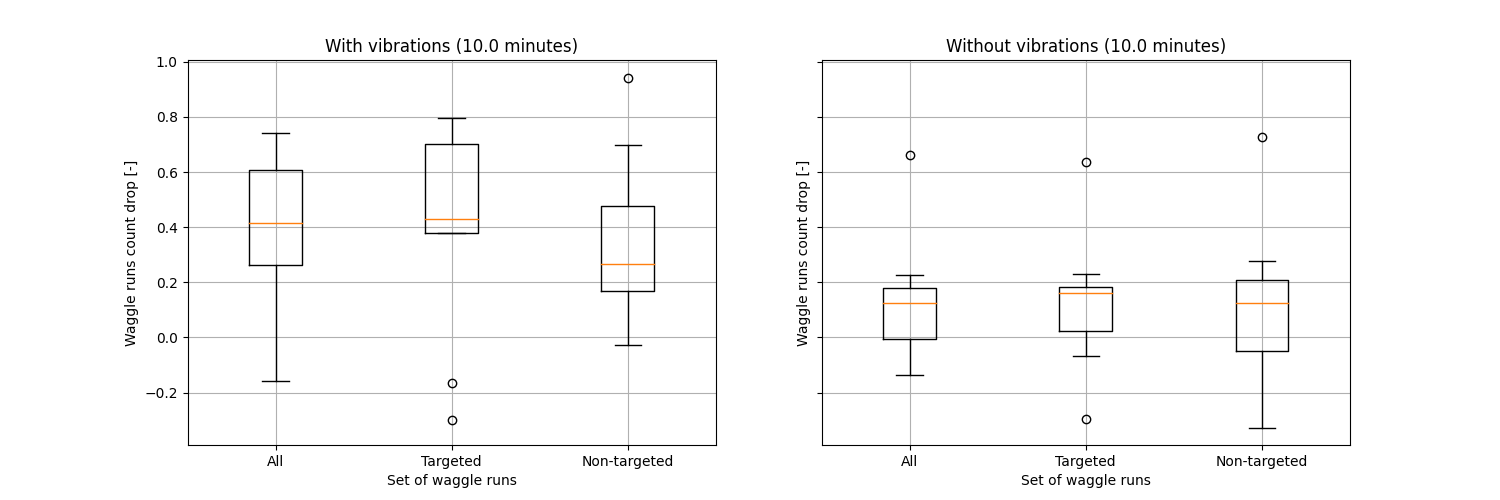

In [8]:
C_drop_exp  = (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs)
NT_drop_exp = (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs)
T_drop_exp  = (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs)

C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

C_drop_blank  = (blank_results.Ccount_ctrl-blank_results.Ccount_vibs)/(blank_results.Ccount_ctrl+blank_results.Ccount_vibs)
NT_drop_blank = (blank_results.NTcount_ctrl-blank_results.NTcount_vibs)/(blank_results.NTcount_ctrl+blank_results.NTcount_vibs)
T_drop_blank  = (blank_results.Tcount_ctrl-blank_results.Tcount_vibs)/(blank_results.Tcount_ctrl+blank_results.Tcount_vibs)

C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([C_drop_exp_nanfree, T_drop_exp_nanfree, NT_drop_exp_nanfree], labels=['All', 'Targeted', 'Non-targeted'])
ax[0].set_title('With vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[0].set_xlabel('Set of waggle runs')
ax[0].set_ylabel('Waggle runs count drop [-]')
ax[0].grid()

ax[1].boxplot([C_drop_blank_nanfree, T_drop_blank_nanfree, NT_drop_blank_nanfree], labels=['All', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[1].set_xlabel('Set of waggle runs')
ax[1].set_ylabel('Waggle runs count drop [-]')
ax[1].grid()

print("Result of test for all waggle runs : {}".format(scipy.stats.ranksums(C_drop_exp_nanfree, C_drop_blank_nanfree)))
print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))
print("Result of test for targeted waggle runs VS NOT targeted ones : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, NT_drop_exp_nanfree)))

Result of test for all waggle runs : RanksumsResult(statistic=2.5597407539187884, pvalue=0.010475027211697008)
Result of test for targeted waggle runs : RanksumsResult(statistic=2.4771684715343114, pvalue=0.0132429375674621)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=2.2294516243808804, pvalue=0.025783870617733164)
Result of test for targeted waggle runs VS NOT targeted ones : RanksumsResult(statistic=1.155231069323108, pvalue=0.24799581483148547)


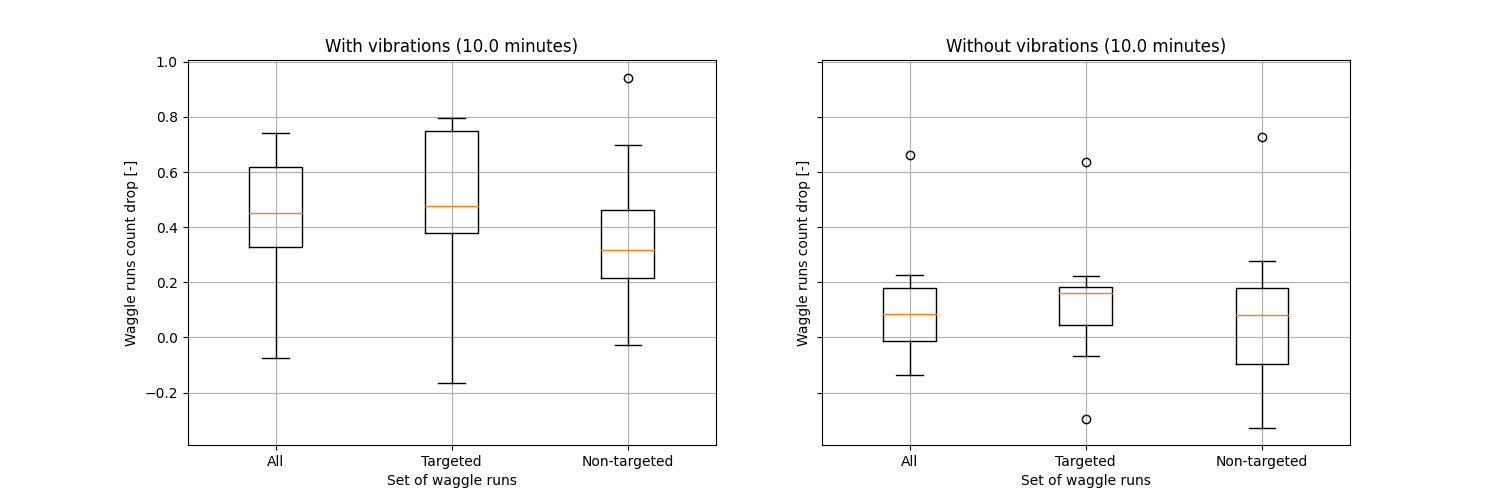

In [9]:
exp_results_conds = exp_results[exp_results.Ccount_ctrl > 200]
blank_results_conds = blank_results[blank_results.Ccount_ctrl > 200]

exp_results_conds = exp_results_conds[exp_results_conds.Ccount_ctrl < 1500]
blank_results_conds = blank_results_conds[blank_results_conds.Ccount_ctrl < 1500]

C_drop_exp  = (exp_results_conds.Ccount_ctrl-exp_results_conds.Ccount_vibs)/(exp_results_conds.Ccount_ctrl+exp_results_conds.Ccount_vibs)
NT_drop_exp = (exp_results_conds.NTcount_ctrl-exp_results_conds.NTcount_vibs)/(exp_results_conds.NTcount_ctrl+exp_results_conds.NTcount_vibs)
T_drop_exp  = (exp_results_conds.Tcount_ctrl-exp_results_conds.Tcount_vibs)/(exp_results_conds.Tcount_ctrl+exp_results_conds.Tcount_vibs)

C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

C_drop_blank  = (blank_results_conds.Ccount_ctrl-blank_results_conds.Ccount_vibs)/(blank_results_conds.Ccount_ctrl+blank_results_conds.Ccount_vibs)
NT_drop_blank = (blank_results_conds.NTcount_ctrl-blank_results_conds.NTcount_vibs)/(blank_results_conds.NTcount_ctrl+blank_results_conds.NTcount_vibs)
T_drop_blank  = (blank_results_conds.Tcount_ctrl-blank_results_conds.Tcount_vibs)/(blank_results_conds.Tcount_ctrl+blank_results_conds.Tcount_vibs)

C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([C_drop_exp_nanfree, T_drop_exp_nanfree, NT_drop_exp_nanfree], labels=['All', 'Targeted', 'Non-targeted'])
ax[0].set_title('With vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[0].set_xlabel('Set of waggle runs')
ax[0].set_ylabel('Waggle runs count drop [-]')
ax[0].grid()

ax[1].boxplot([C_drop_blank_nanfree, T_drop_blank_nanfree, NT_drop_blank_nanfree], labels=['All', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations ({} minutes)'.format(DURATION_EXPERIMENT_2H.total_seconds()/60))
ax[1].set_xlabel('Set of waggle runs')
ax[1].set_ylabel('Waggle runs count drop [-]')
ax[1].grid()

print("Result of test for all waggle runs : {}".format(scipy.stats.ranksums(C_drop_exp_nanfree, C_drop_blank_nanfree)))
print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))
print("Result of test for targeted waggle runs VS NOT targeted ones : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, NT_drop_exp_nanfree)))

## Effect of the vibrations on the number of waggle runs for the 30 mins experiments : Processing

In [10]:
DURATION_30MINS_VAL         = 15.0
DURATION_EXPERIMENT_30MINS  = datetime.timedelta(minutes=DURATION_30MINS_VAL)
results = []

last_target_angle = 0
for exp_i, exp in exp_configs.iterrows():
    # print(exp)

    if exp['dtts_start'] < LIMIT_DATE_EXP or exp['dtts_start'] > LIMIT_DATE_SETUP_STOP :
        continue
    if exp.rule in ['no_vibrate', 'vibrate']:
        times_table     = [[exp['dtts_start']+t_per*DURATION_EXPERIMENT_30MINS, exp['dtts_start']+(t_per+1)*DURATION_EXPERIMENT_30MINS] for t_per in range(int(30/DURATION_30MINS_VAL))] 
    else :
        continue
    
    # Naively take all of the waggles and count them
    for xptimes in times_table :
        res = dict(exp)
        res['type']         = 'blank' if exp.rule == 'no_vibrate' else 'exp'
        res['dtts_start']   = xptimes[0]
        res['dtts_stop']    = xptimes[1]

        runs                = all_waggles_df[all_waggles_df.timestamp_begin > xptimes[0]]
        runs                = runs[runs.timestamp_begin < xptimes[1]]
        res['Ncount']       = len(runs)
    
        # Take only the waggles with high confidence and count them
        runs_confidence     = runs[runs.label_confidence > WR_CONFIDENCE]
        res['Ccount']       = len(runs_confidence)

        # Compare waggle runs that we want to inhibit with others (control --> target angle = target angle of last inhibition phase)
        if res['type'] == 'exp':
            target_angle        = exp.angle_deg
            last_target_angle   = target_angle
        else :
            target_angle        = last_target_angle

        runs_targeted       = runs_confidence[abs((runs_confidence.dance_world_angle_deg%360-target_angle)) < 90]
        runs_not_targeted   = runs_confidence[abs((runs_confidence.dance_world_angle_deg%360-target_angle)) > 90]

        # print(target_angle)
        # print(runs_targeted.dance_world_angle_deg.unique())

        res['Tcount']       = len(runs_targeted)
        res['NTcount']      = len(runs_not_targeted)

        results.append(res)

results_30mins = pandas.DataFrame.from_dict(results)
results_30mins

,from,to,rule,dtts_start,dtts_stop,angle_deg,type,Ncount,Ccount,Tcount,NTcount
0,2023-07-29T12:30:00+02:00,2023-07-29T13:00:00+02:00,vibrate,2023-07-29 12:30:00+02:00,2023-07-29 12:45:00+02:00,314.0,exp,420,418,288,130
1,2023-07-29T12:30:00+02:00,2023-07-29T13:00:00+02:00,vibrate,2023-07-29 12:45:00+02:00,2023-07-29 13:00:00+02:00,314.0,exp,528,522,344,178
2,2023-07-29T13:00:00+02:00,2023-07-29T13:30:00+02:00,no_vibrate,2023-07-29 13:00:00+02:00,2023-07-29 13:15:00+02:00,0.0,blank,1418,1404,788,616
3,2023-07-29T13:00:00+02:00,2023-07-29T13:30:00+02:00,no_vibrate,2023-07-29 13:15:00+02:00,2023-07-29 13:30:00+02:00,0.0,blank,922,910,792,118
4,2023-07-29T13:30:00+02:00,2023-07-29T14:00:00+02:00,vibrate,2023-07-29 13:30:00+02:00,2023-07-29 13:45:00+02:00,116.0,exp,1048,1038,164,874
...,...,...,...,...,...,...,...,...,...,...,...
77,2023-07-31T15:30:00+02:00,2023-07-31T16:00:00+02:00,no_vibrate,2023-07-31 15:45:00+02:00,2023-07-31 16:00:00+02:00,0.0,blank,1508,1490,904,586
78,2023-07-31T16:00:00+02:00,2023-07-31T16:30:00+02:00,vibrate,2023-07-31 16:00:00+02:00,2023-07-31 16:15:00+02:00,314.0,exp,740,732,324,408
79,2023-07-31T16:00:00+02:00,2023-07-31T16:30:00+02:00,vibrate,2023-07-31 16:15:00+02:00,2023-07-31 16:30:00+02:00,314.0,exp,1168,1150,348,802
80,2023-07-31T16:30:00+02:00,2023-07-31T17:00:00+02:00,no_vibrate,2023-07-31 16:30:00+02:00,2023-07-31 16:45:00+02:00,0.0,blank,1604,1584,556,1028


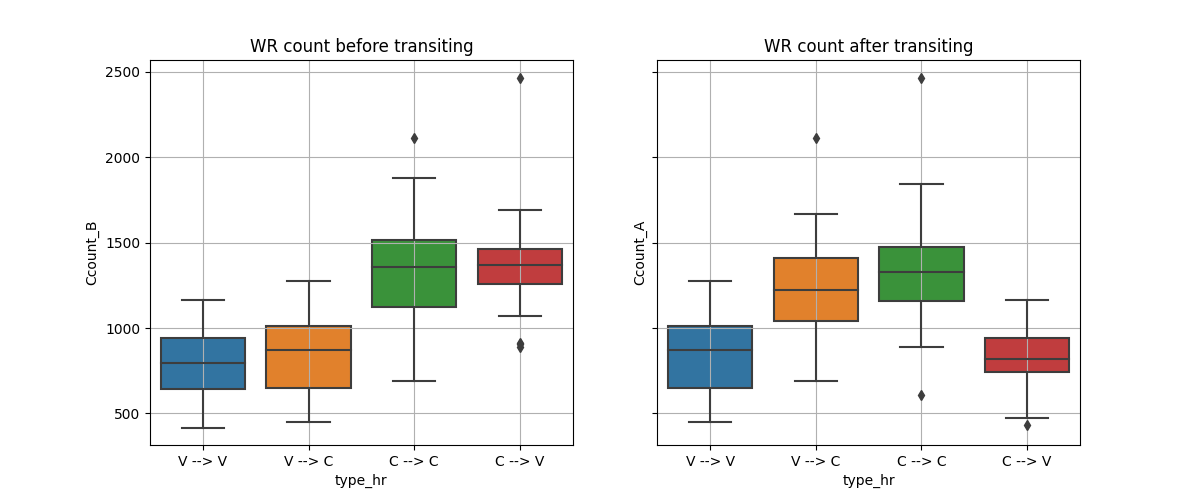

In [11]:
transitions = []
for row_id, row in results_30mins.iterrows():
    if row_id==0:
        continue
    last_row = results_30mins.iloc[row_id-1]

    if not(last_row.dtts_start.date() == row.dtts_start.date()):
        continue

    transition = {}
    transition['ts'] = row.dtts_start

    if row.type == 'exp' and last_row.type == 'exp':
        transition['type']      = 0
        transition['type_hr']   = 'V --> V'
    elif row.type == 'blank' and last_row.type == 'exp':
        transition['type']      = 1
        transition['type_hr']   = 'V --> C'
    elif row.type == 'blank' and last_row.type == 'blank':
        transition['type']      = 2
        transition['type_hr']   = 'C --> C'
    elif row.type == 'exp' and last_row.type == 'blank':
        transition['type']      = 3
        transition['type_hr']   = 'C --> V'
    else :
        transition['type']      = -1
        transition['type_hr']   = None
        print('Unknown case')

    transition['Ccount_B']     = last_row.Ccount
    transition['Ccount_A']     = row.Ccount
    
    transitions.append(transition)

transitions_30mins = pandas.DataFrame.from_dict(transitions)
transitions_30mins

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)
seaborn.boxplot(data=transitions_30mins, y='Ccount_B', x='type_hr', ax=ax[0])
_ = ax[0].set_title('WR count before transiting')
seaborn.boxplot(data=transitions_30mins, y='Ccount_A', x='type_hr', ax=ax[1])
_ = ax[1].set_title('WR count after transiting')
ax[0].grid()
ax[1].grid()


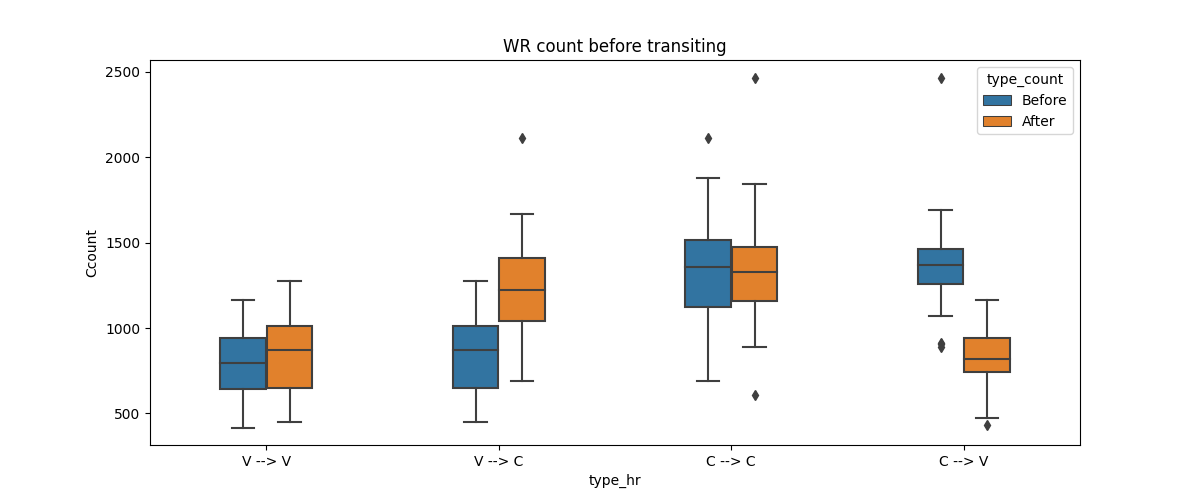

In [12]:
transitions_seaborn = []

for row_id, row in transitions_30mins.iterrows():
    trans_sns = {}
    trans_sns['type_hr'] = row.type_hr
    trans_sns['Ccount'] = row.Ccount_B
    trans_sns['type_count'] = 'Before'
    transitions_seaborn.append(trans_sns.copy())
    trans_sns['Ccount'] = row.Ccount_A
    trans_sns['type_count'] = 'After'
    transitions_seaborn.append(trans_sns)

transitions_seaborn = pandas.DataFrame.from_dict(transitions_seaborn)

fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(12, 5))
seaborn.boxplot(data=transitions_seaborn, x="type_hr", y="Ccount", hue="type_count", ax=ax, width=0.4)
_ = ax.set_title('WR count before transiting')
# ax.grid()


In [13]:
print("Result of test for V->V : {}".format(scipy.stats.ranksums(transitions_30mins[transitions_30mins.type == 0].Ccount_B, transitions_30mins[transitions_30mins.type == 0].Ccount_A)))
print("Result of test for C->C : {}".format(scipy.stats.ranksums(transitions_30mins[transitions_30mins.type == 2].Ccount_B, transitions_30mins[transitions_30mins.type == 2].Ccount_A)))
print("Result of test for V->C : {}".format(scipy.stats.ranksums(transitions_30mins[transitions_30mins.type == 1].Ccount_B, transitions_30mins[transitions_30mins.type == 1].Ccount_A)))
print("Result of test for C->V : {}".format(scipy.stats.ranksums(transitions_30mins[transitions_30mins.type == 3].Ccount_B, transitions_30mins[transitions_30mins.type == 3].Ccount_A)))

transitions_30mins

Result of test for V->V : RanksumsResult(statistic=-0.554700196225229, pvalue=0.5790997419539189)
Result of test for C->C : RanksumsResult(statistic=0.010984590274780682, pvalue=0.991235741264392)
Result of test for V->C : RanksumsResult(statistic=-3.4595775396152444, pvalue=0.0005410234811143693)
Result of test for C->V : RanksumsResult(statistic=4.334488180603079, pvalue=1.4609963729328906e-05)


,ts,type,type_hr,Ccount_B,Ccount_A
0,2023-07-29 12:45:00+02:00,0,V --> V,418,522
1,2023-07-29 13:00:00+02:00,1,V --> C,522,1404
2,2023-07-29 13:15:00+02:00,2,C --> C,1404,910
3,2023-07-29 13:30:00+02:00,3,C --> V,910,1038
4,2023-07-29 13:45:00+02:00,0,V --> V,1038,694
...,...,...,...,...,...
74,2023-07-31 15:45:00+02:00,2,C --> C,2110,1490
75,2023-07-31 16:00:00+02:00,3,C --> V,1490,732
76,2023-07-31 16:15:00+02:00,0,V --> V,732,1150
77,2023-07-31 16:30:00+02:00,1,V --> C,1150,1584


In [14]:
ANGLES                              = [314, 116, 0]
ANGLES_NAMES                        = ['S', 'N', 'C']
DURATION_EXPERIMENT_30MINS_DELTA    = datetime.timedelta(minutes=30.0)

actuation_ratios = pandas.read_pickle(conf_path+'processed_actuation_phases.pickle')


bad_experiments = ['230730T103000', '230730T133000', '230731T090000', '230731T100000', '230731T120000', '230731T140000']#, '230731T080000', '230731T110000', '230731T130000']
bad_experiments_dt = [pytz.utc.localize(datetime.datetime.strptime(be, "%y%m%dT%H%M%S")) for be in bad_experiments]

results = []
count_exp = 0
for exp_i, exp in exp_configs.iterrows():
    # print(exp)

    if exp['dtts_start'] < LIMIT_DATE_EXP or exp['dtts_start'] > LIMIT_DATE_SETUP_STOP :
        continue
    if not(exp.rule in ['no_vibrate', 'vibrate']):
        continue
    
    # Naively take all of the waggles and count them
    count_exp += 1
    res = dict(exp)
    res['count_exp']    = count_exp
    res['type']         = 'blank' if exp.rule == 'no_vibrate' else 'exp'
    res['dtts_start']   = res['from']
    res['dtts_stop']    = res['to']

    if exp['dtts_start'] in bad_experiments_dt:
        continue
    
    ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT_30MINS_DELTA
    ctrl_stop_time  = exp['dtts_start']
    vibs_start_time = exp['dtts_start']
    vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT_30MINS_DELTA

    runs                = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
    runs                = runs[runs.timestamp_begin < vibs_stop_time ]
    res['Ncount']       = len(runs)

    runs_comparative    = all_waggles_df[all_waggles_df.timestamp_begin > ctrl_start_time]
    runs_comparative    = runs_comparative[runs_comparative.timestamp_begin < ctrl_stop_time ]

    # Take only the waggles with high confidence and count them
    runs_confidence     = runs[runs.label_confidence > WR_CONFIDENCE]
    res['Ccount']       = len(runs_confidence)

    # Compare waggle runs that we want to inhibit with others (control --> target angle = target angle of last inhibition phase)
    for ang_id, ang in enumerate(ANGLES):
        if ang == 0:
            continue
        ang_name = ANGLES_NAMES[ang_id]
        count_ang   = len(runs_confidence[abs((runs_confidence.dance_world_angle_deg%360-ang)) < 45])
        count_comp  = len(runs_comparative[abs((runs_comparative.dance_world_angle_deg%360-ang)) < 45])
        res[ang_name+'_count'] = count_ang
        if res['type'] == 'exp':
            if len(results) == 0:
                continue
            res[ang_name+'_drop'] = (count_comp-count_ang)/(count_comp+count_ang)
    if res['type'] == 'exp':       
        res['ratio'] = actuation_ratios[actuation_ratios.ts_start == res['from']].ratio.values[0]
    res['target_angle_hr'] = 'V'+ANGLES_NAMES[numpy.argwhere(numpy.array(ANGLES) == res['angle_deg'])[0,0]]
    results.append(res)

results_directional = pandas.DataFrame.from_dict(results)
results_directional

,from,to,rule,dtts_start,dtts_stop,angle_deg,count_exp,type,Ncount,Ccount,S_count,N_count,ratio,target_angle_hr,S_drop,N_drop
0,2023-07-29T12:30:00+02:00,2023-07-29T13:00:00+02:00,vibrate,2023-07-29T12:30:00+02:00,2023-07-29T13:00:00+02:00,314.0,1,exp,948,940,556,188,0.340524,VS,NaN,NaN
1,2023-07-29T13:00:00+02:00,2023-07-29T13:30:00+02:00,no_vibrate,2023-07-29T13:00:00+02:00,2023-07-29T13:30:00+02:00,0.0,2,blank,2340,2314,1354,424,NaN,VC,NaN,NaN
2,2023-07-29T13:30:00+02:00,2023-07-29T14:00:00+02:00,vibrate,2023-07-29T13:30:00+02:00,2023-07-29T14:00:00+02:00,116.0,3,exp,1750,1732,1264,196,0.160758,VN,0.037319,0.375796
3,2023-07-29T14:00:00+02:00,2023-07-29T14:30:00+02:00,no_vibrate,2023-07-29T14:00:00+02:00,2023-07-29T14:30:00+02:00,0.0,4,blank,2080,2056,1242,556,NaN,VC,NaN,NaN
4,2023-07-29T14:30:00+02:00,2023-07-29T15:00:00+02:00,vibrate,2023-07-29T14:30:00+02:00,2023-07-29T15:00:00+02:00,314.0,5,exp,1072,1060,584,340,0.354723,VS,0.366594,0.246120
5,2023-07-29T15:00:00+02:00,2023-07-29T15:30:00+02:00,no_vibrate,2023-07-29T15:00:00+02:00,2023-07-29T15:30:00+02:00,0.0,6,blank,2056,2032,876,808,NaN,VC,NaN,NaN
6,2023-07-29T15:30:00+02:00,2023-07-29T16:00:00+02:00,vibrate,2023-07-29T15:30:00+02:00,2023-07-29T16:00:00+02:00,116.0,7,exp,1500,1486,832,404,0.315834,VN,0.032558,0.337705
7,2023-07-29T16:00:00+02:00,2023-07-29T16:30:00+02:00,no_vibrate,2023-07-29T16:00:00+02:00,2023-07-29T16:30:00+02:00,0.0,8,blank,1598,1584,802,508,NaN,VC,NaN,NaN
8,2023-07-30T09:30:00+02:00,2023-07-30T10:00:00+02:00,no_vibrate,2023-07-30T09:30:00+02:00,2023-07-30T10:00:00+02:00,0.0,9,blank,3378,3360,1282,828,NaN,VC,NaN,NaN
9,2023-07-30T10:00:00+02:00,2023-07-30T10:30:00+02:00,no_vibrate,2023-07-30T10:00:00+02:00,2023-07-30T10:30:00+02:00,0.0,10,blank,3000,2972,1288,708,NaN,VC,NaN,NaN


Result of test for SOUTH waggle runs COUNT: RanksumsResult(statistic=-3.0, pvalue=0.0026997960632601866)
Result of test for SOUTH waggle runs COUNT: RanksumsResult(statistic=-1.1212238211627763, pvalue=0.2621926024067731)
Result of test for NORTH waggle runs COUNT: RanksumsResult(statistic=-0.2857142857142857, pvalue=0.7750969621959847)
Result of test for SOUTH waggle runs DROP: RanksumsResult(statistic=2.6795932117057952, pvalue=0.007371167746956715)
Result of test for NORTH waggle runs DROP: RanksumsResult(statistic=0.08119979429411502, pvalue=0.935283063107044)


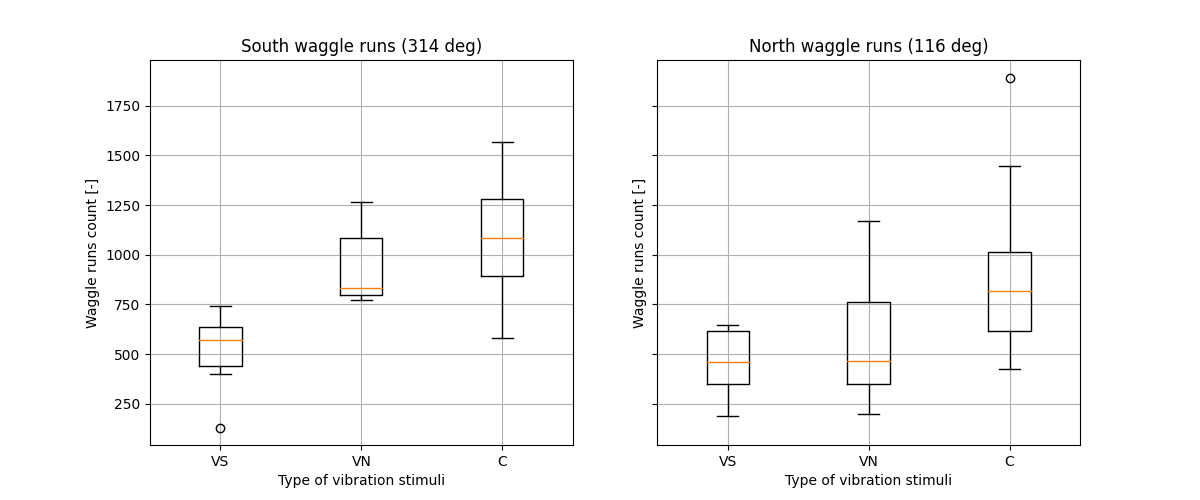

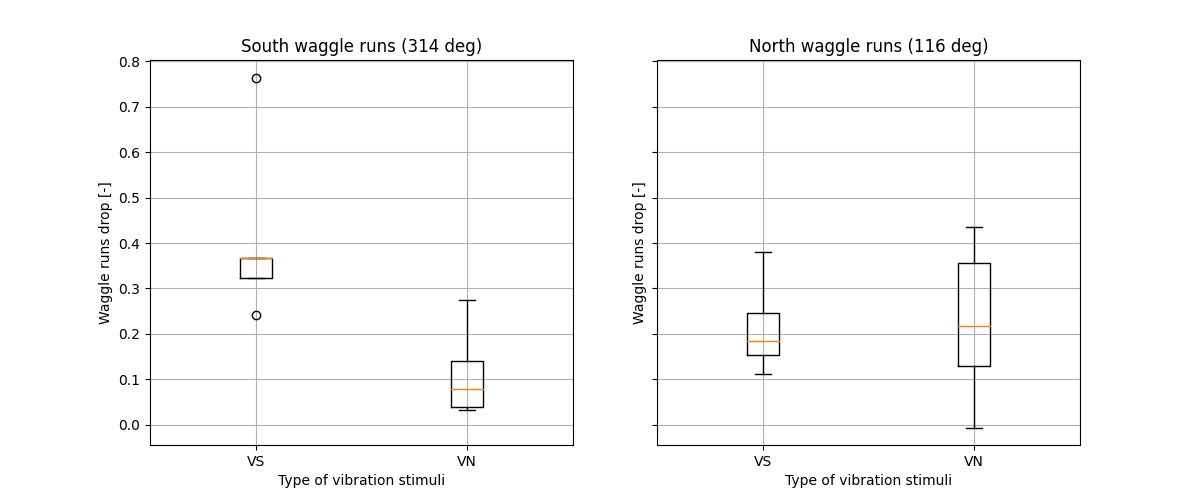

In [15]:
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)

# ax[0,0].plot(results_directional.dtts_start, results_directional.VS_count)
# ax[1,0].plot(results_directional.dtts_start, results_directional.VN_count)

res_VS  = results_directional[results_directional.target_angle_hr == 'VS']
res_VN  = results_directional[results_directional.target_angle_hr == 'VN']
res_C   = results_directional[results_directional.target_angle_hr == 'VC']

res_VS_drop  = res_VS[~numpy.isnan(res_VS.S_drop)]
res_VN_drop  = res_VN[~numpy.isnan(res_VN.S_drop)]

ax[0].boxplot([res_VS.S_count, res_VN.S_count, res_C.S_count], labels=['VS', 'VN', 'C'])
ax[0].set_title('South waggle runs (314 deg)')
ax[0].set_xlabel('Type of vibration stimuli')
ax[0].set_ylabel('Waggle runs count [-]')
ax[0].grid()

ax[1].boxplot([res_VS.N_count, res_VN.N_count, res_C.N_count], labels=['VS', 'VN', 'C'])
ax[1].set_title('North waggle runs (116 deg)')
ax[1].set_xlabel('Type of vibration stimuli')
ax[1].set_ylabel('Waggle runs count [-]')
ax[1].grid()


fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12, 5), sharey=True)

ax[0].boxplot([res_VS_drop.S_drop, res_VN_drop.S_drop], labels=['VS', 'VN'])
ax[0].set_title('South waggle runs (314 deg)')
ax[0].set_xlabel('Type of vibration stimuli')
ax[0].set_ylabel('Waggle runs drop [-]')
ax[0].grid()

ax[1].boxplot([res_VS_drop.N_drop, res_VN_drop.N_drop], labels=['VS', 'VN'])
ax[1].set_title('North waggle runs (116 deg)')
ax[1].set_xlabel('Type of vibration stimuli')
ax[1].set_ylabel('Waggle runs drop [-]')
ax[1].grid()

print("Result of test for SOUTH waggle runs COUNT: {}".format(scipy.stats.ranksums(res_VS.S_count, res_VN.S_count)))
print("Result of test for SOUTH waggle runs COUNT: {}".format(scipy.stats.ranksums(res_VN.S_count, res_C.S_count)))
print("Result of test for NORTH waggle runs COUNT: {}".format(scipy.stats.ranksums(res_VS.N_count, res_VN.N_count)))

print("Result of test for SOUTH waggle runs DROP: {}".format(scipy.stats.ranksums(res_VS_drop.S_drop, res_VN_drop.S_drop)))
print("Result of test for NORTH waggle runs DROP: {}".format(scipy.stats.ranksums(res_VS_drop.N_drop, res_VN_drop.N_drop)))

In [16]:
res_VN_drop

,from,to,rule,dtts_start,dtts_stop,angle_deg,count_exp,type,Ncount,Ccount,S_count,N_count,ratio,target_angle_hr,S_drop,N_drop
2,2023-07-29T13:30:00+02:00,2023-07-29T14:00:00+02:00,vibrate,2023-07-29T13:30:00+02:00,2023-07-29T14:00:00+02:00,116.0,3,exp,1750,1732,1264,196,0.160758,VN,0.037319,0.375796
6,2023-07-29T15:30:00+02:00,2023-07-29T16:00:00+02:00,vibrate,2023-07-29T15:30:00+02:00,2023-07-29T16:00:00+02:00,116.0,7,exp,1500,1486,832,404,0.315834,VN,0.032558,0.337705
10,2023-07-30T10:30:00+02:00,2023-07-30T11:00:00+02:00,vibrate,2023-07-30T10:30:00+02:00,2023-07-30T11:00:00+02:00,116.0,11,exp,2186,2178,1188,464,0.315375,VN,0.042707,0.217538
17,2023-07-30T14:30:00+02:00,2023-07-30T15:00:00+02:00,vibrate,2023-07-30T14:30:00+02:00,2023-07-30T15:00:00+02:00,116.0,19,exp,1722,1700,976,290,0.216931,VN,0.078376,0.435798
20,2023-07-30T16:30:00+02:00,2023-07-30T17:00:00+02:00,vibrate,2023-07-30T16:30:00+02:00,2023-07-30T17:00:00+02:00,116.0,23,exp,1600,1586,798,484,0.331091,VN,0.274545,0.149385
29,2023-07-31T13:00:00+02:00,2023-07-31T13:30:00+02:00,vibrate,2023-07-31T13:00:00+02:00,2023-07-31T13:30:00+02:00,116.0,34,exp,2192,2180,796,1040,0.345555,VN,0.180227,-0.005803
32,2023-07-31T15:00:00+02:00,2023-07-31T15:30:00+02:00,vibrate,2023-07-31T15:00:00+02:00,2023-07-31T15:30:00+02:00,116.0,38,exp,2300,2284,770,1172,0.302742,VN,0.102564,0.108067


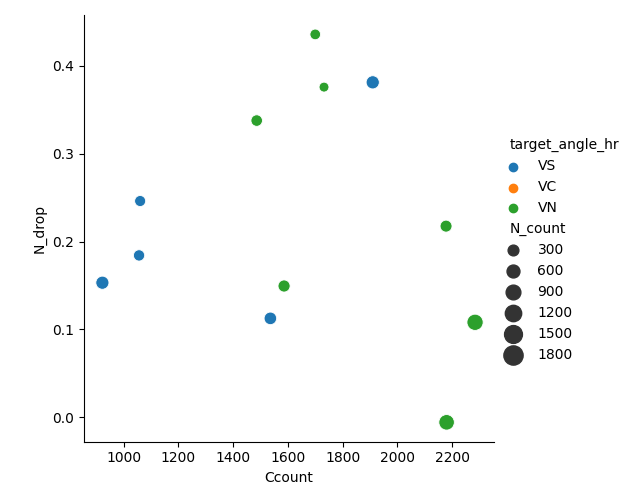

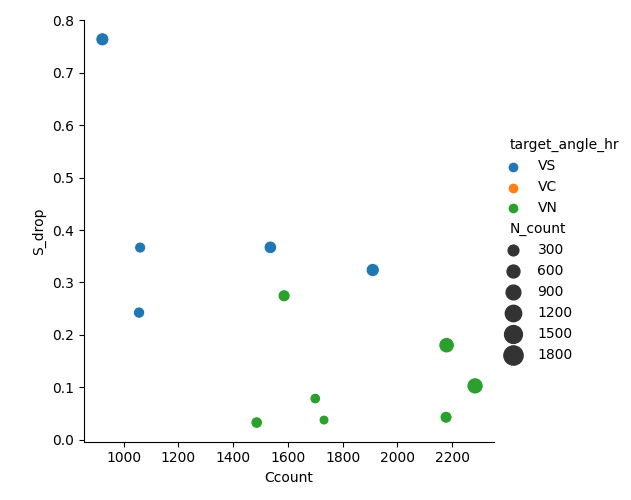

In [17]:
results_directional_seaborn = results_directional
# results_directional_seaborn['diffS_N'] = results_directional_seaborn.S_count - results_directional_seaborn.N_count
# fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(12, 5))
seaborn.relplot(data=results_directional, y="N_drop", x="Ccount", hue="target_angle_hr", size='N_count', sizes=(50, 200))
seaborn.relplot(data=results_directional, y="S_drop", x="Ccount", hue="target_angle_hr", size='N_count', sizes=(50, 200))
# _ = ax.set_title('WR count before transiting')

# Figures creation

## Waggle run reduction

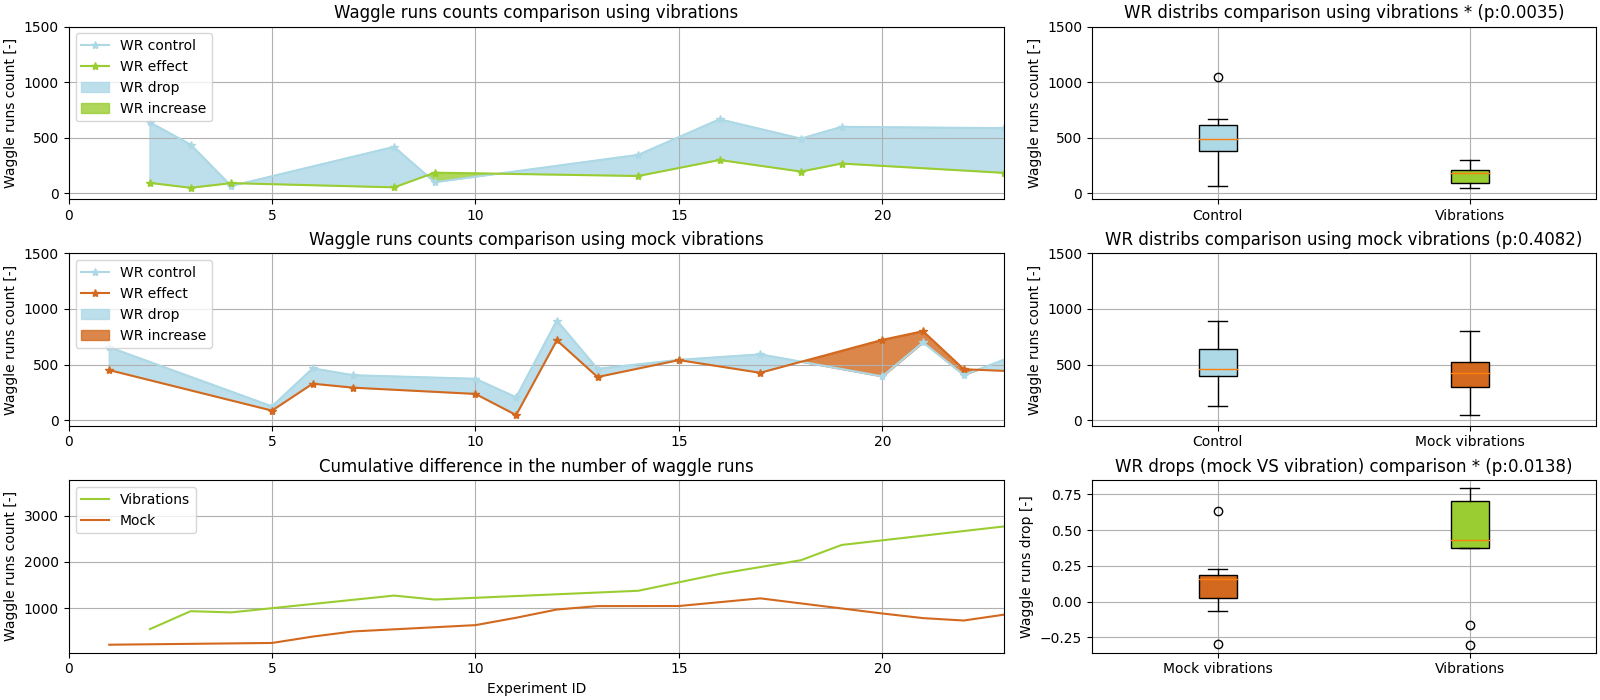

In [18]:
fig, ax = matplotlib.pyplot.subplots(3, 2, figsize=(16,7), height_ratios=[30, 30, 30], width_ratios=[65, 35], constrained_layout=True)

COLOR_CONTROL   = 'lightblue'
COLOR_MOCK      = 'chocolate'
COLOR_VIBS      = 'yellowgreen'
_ = ax[0,0].plot(results_2h[results_2h.type=='exp'].count_exp, results_2h[results_2h.type=='exp'].Tcount_ctrl, marker='*', label='WR control', color=COLOR_CONTROL)
_ = ax[0,0].plot(results_2h[results_2h.type=='exp'].count_exp, results_2h[results_2h.type=='exp'].Tcount_vibs, marker='*', label='WR effect', color=COLOR_VIBS)
_ = ax[0,0].fill_between(results_2h[results_2h.type=='exp'].count_exp, results_2h[results_2h.type=='exp'].Tcount_vibs, results_2h[results_2h.type=='exp'].Tcount_ctrl, where=(results_2h[results_2h.type=='exp'].Tcount_vibs < results_2h[results_2h.type=='exp'].Tcount_ctrl), color=COLOR_CONTROL, alpha=0.8, interpolate=True, label='WR drop')
_ = ax[0,0].fill_between(results_2h[results_2h.type=='exp'].count_exp, results_2h[results_2h.type=='exp'].Tcount_vibs, results_2h[results_2h.type=='exp'].Tcount_ctrl, where=(results_2h[results_2h.type=='exp'].Tcount_vibs > results_2h[results_2h.type=='exp'].Tcount_ctrl), color=COLOR_VIBS, alpha=0.8, interpolate=True, label='WR increase')

_ = ax[1,0].plot(results_2h[results_2h.type=='blank'].count_exp, results_2h[results_2h.type=='blank'].Tcount_ctrl, marker='*', label='WR control', color=COLOR_CONTROL)
_ = ax[1,0].plot(results_2h[results_2h.type=='blank'].count_exp, results_2h[results_2h.type=='blank'].Tcount_vibs, marker='*', label='WR effect', color=COLOR_MOCK)
_ = ax[1,0].fill_between(results_2h[results_2h.type=='blank'].count_exp, results_2h[results_2h.type=='blank'].Tcount_vibs, results_2h[results_2h.type=='blank'].Tcount_ctrl, where=(results_2h[results_2h.type=='blank'].Tcount_vibs < results_2h[results_2h.type=='blank'].Tcount_ctrl), color=COLOR_CONTROL, alpha=0.8, interpolate=True, label='WR drop')
_ = ax[1,0].fill_between(results_2h[results_2h.type=='blank'].count_exp, results_2h[results_2h.type=='blank'].Tcount_vibs, results_2h[results_2h.type=='blank'].Tcount_ctrl, where=(results_2h[results_2h.type=='blank'].Tcount_vibs > results_2h[results_2h.type=='blank'].Tcount_ctrl), color=COLOR_MOCK, alpha=0.8, interpolate=True, label='WR increase')

bplot = ax[0,1].boxplot([results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs], labels=['Control', 'Vibrations'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[1,1].boxplot([results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs], labels=['Control', 'Mock vibrations'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_MOCK)

_ = ax[2,0].plot(results_2h[results_2h.type=='exp'].count_exp, numpy.cumsum(results_2h[results_2h.type=='exp'].Tcount_ctrl-results_2h[results_2h.type=='exp'].Tcount_vibs), label='Vibrations', color=COLOR_VIBS)
_ = ax[2,0].plot(results_2h[results_2h.type=='blank'].count_exp, numpy.cumsum(results_2h[results_2h.type=='blank'].Tcount_ctrl-results_2h[results_2h.type=='blank'].Tcount_vibs), label='Mock', color=COLOR_MOCK)

distribution_dropT_vibs = (results_2h[results_2h.type=='exp'].Tcount_ctrl - results_2h[results_2h.type=='exp'].Tcount_vibs) / (results_2h[results_2h.type=='exp'].Tcount_ctrl + results_2h[results_2h.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = (results_2h[results_2h.type=='blank'].Tcount_ctrl - results_2h[results_2h.type=='blank'].Tcount_vibs) / (results_2h[results_2h.type=='blank'].Tcount_ctrl + results_2h[results_2h.type=='blank'].Tcount_vibs)
bplot = ax[2,1].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Mock vibrations', 'Vibrations'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_MOCK)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)


# Titles 
_ = ax[0,0].title.set_text('Waggle runs counts comparison using vibrations')
_ = ax[1,0].title.set_text('Waggle runs counts comparison using mock vibrations')
_ = ax[2,0].title.set_text('Cumulative difference in the number of waggle runs')

RStest_exp = scipy.stats.ranksums(results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[0,1].title.set_text('WR distribs comparison using vibrations * (p:{1:1.4f})'.format(RStest_exp[0], RStest_exp[1]))
_ = ax[1,1].title.set_text('WR distribs comparison using mock vibrations (p:{1:1.4f})'.format(RStest_ctl[0], RStest_ctl[1]))
_ = ax[2,1].title.set_text('WR drops (mock VS vibration) comparison * (p:{1:1.4f})'.format(RStest_drop[0], RStest_drop[1]))

# Axis names
_ = ax[2,0].set_xlabel('Experiment ID')
_ = ax[0,0].set_ylabel('Waggle runs count [-]')
_ = ax[1,0].set_ylabel('Waggle runs count [-]')
_ = ax[2,0].set_ylabel('Waggle runs count [-]')

_ = ax[0,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,1].set_ylabel('Waggle runs count [-]')
_ = ax[2,1].set_ylabel('Waggle runs drop [-]')

# Axis limits
YLIM_WR = [-50, 1500]
_ = ax[0,0].set_ylim(YLIM_WR)
_ = ax[1,0].set_ylim(YLIM_WR)
_ = ax[0,1].set_ylim(YLIM_WR)
_ = ax[1,1].set_ylim(YLIM_WR)

XLIM_EXP = [0, 23]
_ = ax[0,0].set_xlim(XLIM_EXP)
_ = ax[1,0].set_xlim(XLIM_EXP)
_ = ax[2,0].set_xlim(XLIM_EXP)

# Legends
_ = ax[0,0].legend(loc='upper left')
_ = ax[1,0].legend(loc='upper left')
_ = ax[2,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[2,0].grid()
_ = ax[0,1].grid()
_ = ax[1,1].grid()
_ = ax[2,1].grid()


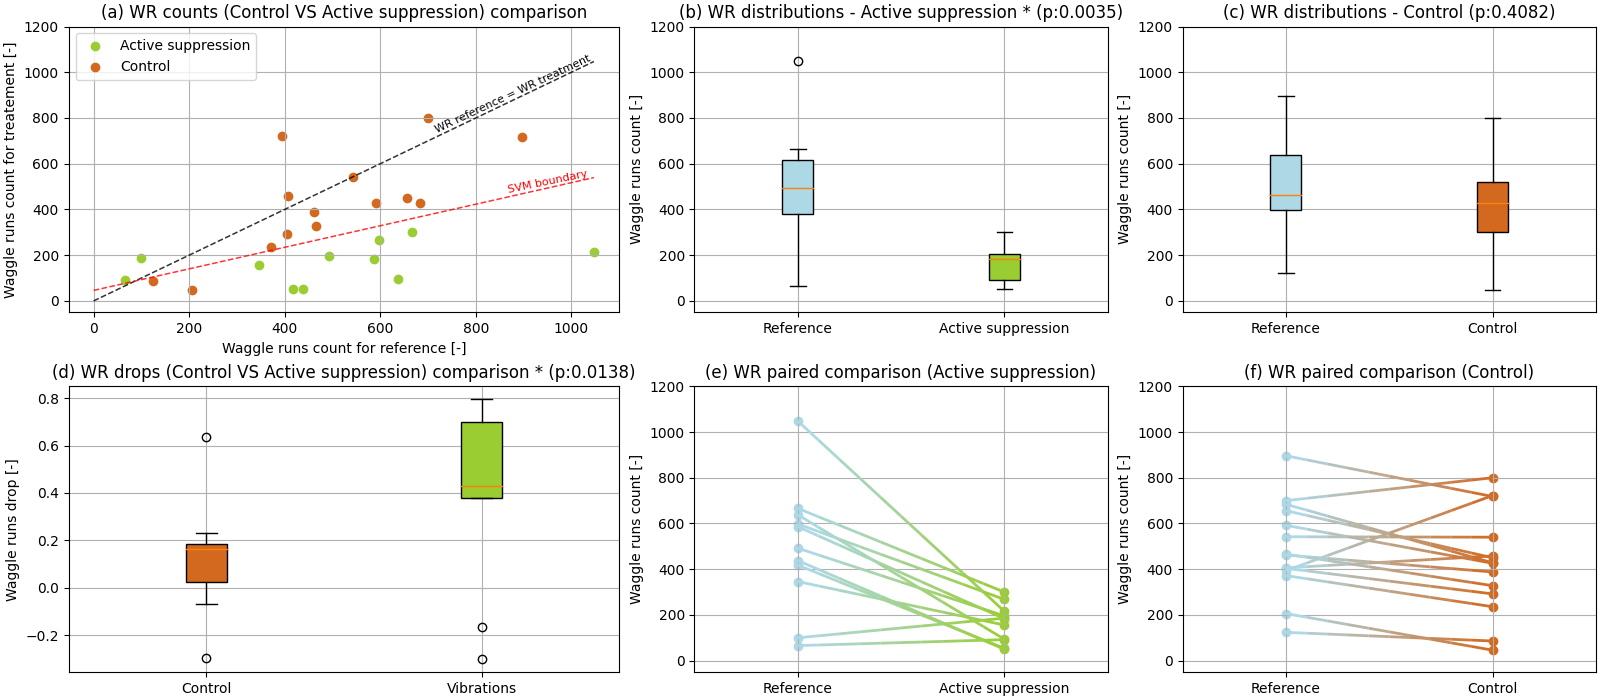

In [19]:
fig, ax = matplotlib.pyplot.subplots(2, 3, figsize=(16,7), height_ratios=[30, 30], width_ratios=[40, 30, 30], constrained_layout=True)

COLOR_REFERENCE = 'lightblue'
COLOR_CONTROL   = 'chocolate'
COLOR_VIBS      = 'yellowgreen'

x_y_line = range(max(results_2h.Tcount_ctrl.max(), results_2h.Tcount_vibs.max()))
text_location = numpy.array((x_y_line[-330], x_y_line[-330]))
trans_angle = ax[0,0].transData.transform_angles(numpy.array((40,)), text_location.reshape((1, 2)))[0]
_ = ax[0,0].plot(x_y_line, x_y_line, linestyle='dashed', c='k', linewidth=1.1, alpha=0.8)
_ = ax[0,0].text(text_location[0], text_location[1]+15, 'WR reference = WR treatment', fontsize=8, rotation=trans_angle, rotation_mode='anchor')

_ = ax[0,0].scatter(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# SVM for separation
X = numpy.concatenate((numpy.expand_dims(results_2h.Tcount_ctrl.values, axis=1), numpy.expand_dims(results_2h.Tcount_vibs.values, axis=1)), axis=1)
y = results_2h.type
svc_model = sklearn.svm.SVC(kernel='linear')
svc_model.fit(X, y)
slope = -svc_model.coef_[0,0]/svc_model.coef_[0,1]
inter = -svc_model.intercept_[0]/svc_model.coef_[0,1]
_ = ax[0,0].plot(x_y_line, numpy.array(x_y_line)*slope+inter, linestyle='dashed', c='r', linewidth=1.1, alpha=0.8)
text_location = numpy.array((x_y_line[-180], x_y_line[-180]*slope+inter))
trans_angle = ax[0,0].transData.transform_angles(numpy.array((math.atan(slope)*180/3.14-5,)), text_location.reshape((1, 2)))[0]
_ = ax[0,0].text(text_location[0], text_location[1]+15, 'SVM boundary', fontsize=8, rotation=trans_angle, rotation_mode='anchor', color='r')

bplot = ax[0,1].boxplot([results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs], labels=['Reference', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,2].boxplot([results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)

distribution_dropT_vibs = (results_2h[results_2h.type=='exp'].Tcount_ctrl - results_2h[results_2h.type=='exp'].Tcount_vibs) / (results_2h[results_2h.type=='exp'].Tcount_ctrl + results_2h[results_2h.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = (results_2h[results_2h.type=='blank'].Tcount_ctrl - results_2h[results_2h.type=='blank'].Tcount_vibs) / (results_2h[results_2h.type=='blank'].Tcount_ctrl + results_2h[results_2h.type=='blank'].Tcount_vibs)
bplot = ax[1,0].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Vibrations'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)

# line plots
color_gradient      = matplotlib.pyplot.Normalize(0, 1)
COLORMAP_GRAD_VIBS  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_VIBS], N=30)
COLORMAP_GRAD_MOCK  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_CONTROL], N=30)
COLORMAP_GRAD_COMP  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE, COLOR_VIBS], N=30)

x_segments          = list(numpy.linspace(0, 1, 11))

points_vibs_wrs     = [numpy.array([[x, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_2h[results_2h.type=='exp'].iterrows()]
points_vibs_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_vibs_wrs]
segments_vibs_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_vibs_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_VIBS, norm=color_gradient) for segments_set in list(segments_vibs_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([0]*len(results_2h[results_2h.type=='exp']), results_2h[results_2h.type=='exp'].Tcount_ctrl, color=COLOR_REFERENCE)
ax[1,1].scatter([1]*len(results_2h[results_2h.type=='exp']), results_2h[results_2h.type=='exp'].Tcount_vibs, color=COLOR_VIBS)

points_mock_wrs     = [numpy.array([[x, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_2h[results_2h.type=='blank'].iterrows()]
points_mock_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_mock_wrs]
segments_mock_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_mock_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_MOCK, norm=color_gradient) for segments_set in list(segments_mock_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,2].add_collection(lines_set) for lines_set in lines]
ax[1,2].scatter([0]*len(results_2h[results_2h.type=='blank']), results_2h[results_2h.type=='blank'].Tcount_ctrl, color=COLOR_REFERENCE)
ax[1,2].scatter([1]*len(results_2h[results_2h.type=='blank']), results_2h[results_2h.type=='blank'].Tcount_vibs, color=COLOR_CONTROL)


# Titles 
_ = ax[0,0].title.set_text('(a) WR counts (Control VS Active suppression) comparison')

RStest_exp = scipy.stats.ranksums(results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[0,1].title.set_text('(b) WR distributions - Active suppression * (p:{1:1.4f})'.format(RStest_exp[0], RStest_exp[1]))
_ = ax[0,2].title.set_text('(c) WR distributions - Control (p:{1:1.4f})'.format(RStest_ctl[0], RStest_ctl[1]))
_ = ax[1,0].title.set_text('(d) WR drops (Control VS Active suppression) comparison * (p:{1:1.4f})'.format(RStest_drop[0], RStest_drop[1]))

_ = ax[1,1].title.set_text('(e) WR paired comparison (Active suppression)')
_ = ax[1,2].title.set_text('(f) WR paired comparison (Control)')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')

_ = ax[0,1].set_ylabel('Waggle runs count [-]')
_ = ax[0,2].set_ylabel('Waggle runs count [-]')
_ = ax[1,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,2].set_ylabel('Waggle runs count [-]')
_ = ax[1,0].set_ylabel('Waggle runs drop [-]')

# ticks
_ = ax[1,1].set_xticks([0, 1])
_ = ax[1,1].set_xticklabels(['Reference', 'Active suppression'])
_ = ax[1,2].set_xticks([0, 1])
_ = ax[1,2].set_xticklabels(['Reference', 'Control'])

# Axis limits
YLIM_WR = [-50, 1200]
_ = ax[0,0].set_ylim(YLIM_WR)
_ = ax[0,1].set_ylim(YLIM_WR)
_ = ax[0,2].set_ylim(YLIM_WR)
_ = ax[1,1].set_ylim(YLIM_WR)
_ = ax[1,2].set_ylim(YLIM_WR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.5, 2.5]
XLIM_TYPE2 = [-0.5, 1.5]
_ = ax[0,1].set_xlim(XLIM_TYPE1)
_ = ax[0,2].set_xlim(XLIM_TYPE1)
_ = ax[1,0].set_xlim(XLIM_TYPE1)
_ = ax[1,1].set_xlim(XLIM_TYPE2)
_ = ax[1,2].set_xlim(XLIM_TYPE2)

# Legends
_ = ax[0,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[0,2].grid()
_ = ax[1,1].grid()
_ = ax[1,2].grid()

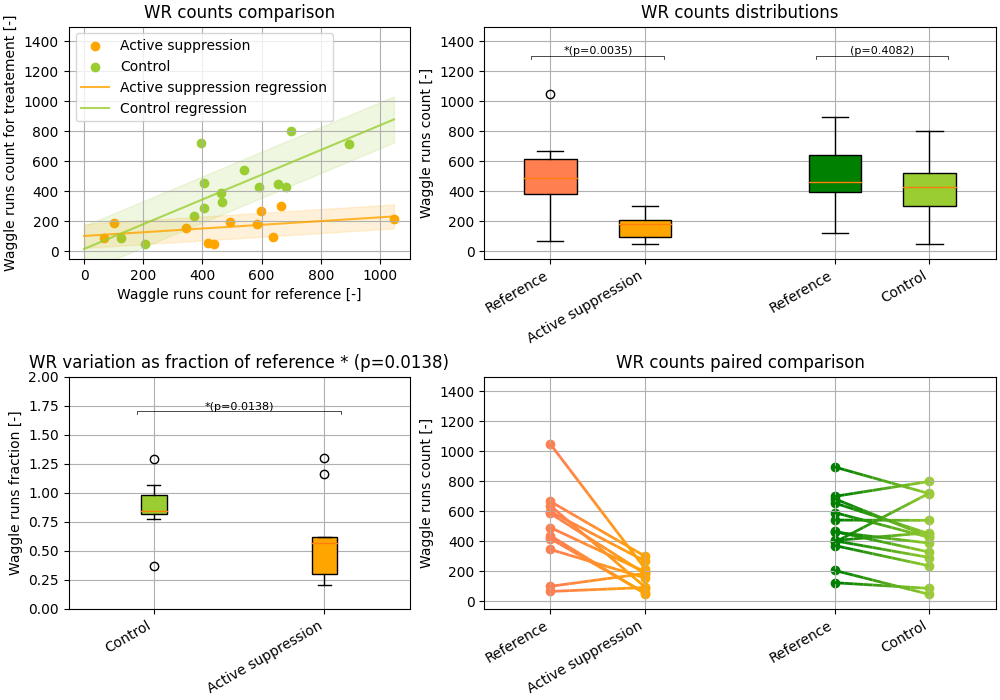

In [20]:
fig, ax = matplotlib.pyplot.subplots(2, 2, figsize=(10,7), height_ratios=[30, 30], width_ratios=[40, 60], constrained_layout=True)

COLOR_REFERENCE_CONTROL = 'green'
COLOR_CONTROL           = 'yellowgreen'
COLOR_REFERENCE_VIBS    = 'coral'
COLOR_VIBS              = 'orange'

_ = ax[0,0].scatter(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0,0].scatter(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_2h[results_2h.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_2h[results_2h.type == 'blank'].Tcount_ctrl)-2))
x_lines = range(max(results_2h.Tcount_ctrl.max(), results_2h.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[0,0].plot(x_lines, y_exp, c=COLOR_VIBS, label='Active suppression regression', alpha=0.8)
_ = ax[0,0].plot(x_lines, y_blank, c=COLOR_CONTROL, label='Control regression', alpha=0.8)
_ = ax[0,0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_VIBS, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_CONTROL, alpha=0.15)#, label='Control STD regression')

bplot = ax[0,1].boxplot([results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_VIBS)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[0,1].boxplot([results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Control'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)

distribution_dropT_vibs = 1 - (results_2h[results_2h.type=='exp'].Tcount_ctrl - results_2h[results_2h.type=='exp'].Tcount_vibs) / (results_2h[results_2h.type=='exp'].Tcount_ctrl + results_2h[results_2h.type=='exp'].Tcount_vibs)
distribution_dropT_ctrl = 1 - (results_2h[results_2h.type=='blank'].Tcount_ctrl - results_2h[results_2h.type=='blank'].Tcount_vibs) / (results_2h[results_2h.type=='blank'].Tcount_ctrl + results_2h[results_2h.type=='blank'].Tcount_vibs)
bplot = ax[1,0].boxplot([distribution_dropT_ctrl, distribution_dropT_vibs], labels=['Control', 'Active suppression'], patch_artist=True)
bplot['boxes'][0].set_facecolor(COLOR_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)

# line plots
color_gradient      = matplotlib.pyplot.Normalize(0, 1)
COLORMAP_GRAD_VIBS  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_VIBS, COLOR_VIBS], N=30)
COLORMAP_GRAD_MOCK  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_CONTROL, COLOR_CONTROL], N=30)
COLORMAP_GRAD_COMP  = matplotlib.colors.LinearSegmentedColormap.from_list("Custom", [COLOR_REFERENCE_VIBS, COLOR_VIBS], N=30)

x_segments          = list(numpy.linspace(0, 1, 11))

points_vibs_wrs     = [numpy.array([[x+1, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_2h[results_2h.type=='exp'].iterrows()]
points_vibs_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_vibs_wrs]
segments_vibs_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_vibs_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_VIBS, norm=color_gradient) for segments_set in list(segments_vibs_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([1]*len(results_2h[results_2h.type=='exp']), results_2h[results_2h.type=='exp'].Tcount_ctrl, color=COLOR_REFERENCE_VIBS)
ax[1,1].scatter([2]*len(results_2h[results_2h.type=='exp']), results_2h[results_2h.type=='exp'].Tcount_vibs, color=COLOR_VIBS)

points_mock_wrs     = [numpy.array([[x+4, row.Tcount_ctrl + (-row.Tcount_ctrl+row.Tcount_vibs)*x] for x in x_segments]) for _, row in results_2h[results_2h.type=='blank'].iterrows()]
points_mock_wrs     = [numpy.expand_dims(points_set, axis=1) for points_set in points_mock_wrs]
segments_mock_wrs   = [numpy.concatenate([points_set[:-1], points_set[1:]], axis=1) for points_set in list(points_mock_wrs)]
lines               = [matplotlib.collections.LineCollection(segments_set, cmap=COLORMAP_GRAD_MOCK, norm=color_gradient) for segments_set in list(segments_mock_wrs)]
_ = [lines_set.set_array(x_segments) for lines_set in lines]
_ = [lines_set.set_linewidth(2) for lines_set in lines]
line = [ax[1,1].add_collection(lines_set) for lines_set in lines]
ax[1,1].scatter([4]*len(results_2h[results_2h.type=='blank']), results_2h[results_2h.type=='blank'].Tcount_ctrl, color=COLOR_REFERENCE_CONTROL)
ax[1,1].scatter([5]*len(results_2h[results_2h.type=='blank']), results_2h[results_2h.type=='blank'].Tcount_vibs, color=COLOR_CONTROL)


# Titles 
_ = ax[0,0].title.set_text('WR counts comparison')

RStest_exp = scipy.stats.ranksums(results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[0,1].title.set_text('WR counts distributions')
_ = ax[1,0].title.set_text('WR variation as fraction of reference * (p={:1.4f})'.format(RStest_drop[1]))

_ = ax[1,1].title.set_text('WR counts paired comparison')

# Axis names
_ = ax[0,0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[0,0].set_ylabel('Waggle runs count for treatement [-]')

_ = ax[0,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,1].set_ylabel('Waggle runs count [-]')
_ = ax[1,0].set_ylabel('Waggle runs fraction [-]')

# ticks
_ = ax[1,1].set_xticks([1, 2, 4, 5])
_ = ax[1,1].set_xticklabels(['Reference', 'Active suppression', 'Reference', 'Control'], rotation=30, ha='right')
_ = ax[0,1].set_xticklabels(['Reference', 'Active suppression', 'Reference', 'Control'], rotation=30, ha='right')
_ = ax[1,0].set_xticklabels(['Control', 'Active suppression'], rotation=30, ha='right')

# Axis limits
YLIM_WR     = [-50, 1500]
YLIM_VAR    = [0, 2]
_ = ax[0,0].set_ylim(YLIM_WR)
_ = ax[0,1].set_ylim(YLIM_WR)
_ = ax[1,1].set_ylim(YLIM_WR)
_ = ax[1,0].set_ylim(YLIM_VAR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.3, 5.7]
XLIM_TYPE2 = [0.5, 2.5]
_ = ax[0,1].set_xlim(XLIM_TYPE1)
_ = ax[1,0].set_xlim(XLIM_TYPE2)
_ = ax[1,1].set_xlim(XLIM_TYPE1)

# Legends
_ = ax[0,0].legend(loc='upper left')

# Grids
_ = ax[0,0].grid()
_ = ax[1,0].grid()
_ = ax[0,1].grid()
_ = ax[1,1].grid()

# Significance bars
sb_level    = 1300
sb_width    = 1.4
sb_height   = 20
sb_positions= [1.5, 4.5]
_ = ax[0,1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[0,1].text(sb_positions[0], sb_level+15, '*(p={:1.4f})'.format(RStest_exp[1]), fontsize=8, horizontalalignment='center')
_ = ax[0,1].text(sb_positions[1], sb_level+15, '(p={:1.4f})'.format(RStest_ctl[1]), fontsize=8, horizontalalignment='center')


sb_level    = 1.7
sb_width    = 1.2
sb_height   = 0.02
sb_positions= [1.5]
_ = ax[1,0].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1,0].text(sb_positions[0], sb_level+0.015, '*(p={:1.4f})'.format(RStest_drop[1]), fontsize=8, horizontalalignment='center')

Feature Importances: [0.41912572 0.2309918  0.34988248]


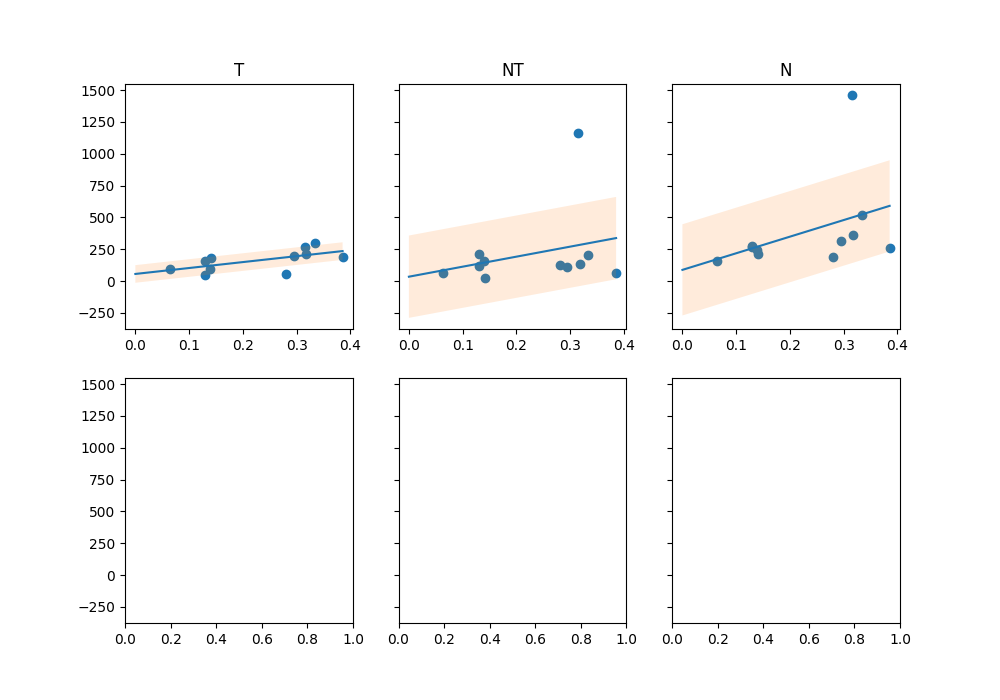

In [21]:
results_actuation = results_2h.copy()

ratios = []
for row_id, row in results_actuation.iterrows():
    actuation_ratio = actuation_ratios[actuation_ratios.ts_start == row['from']].ratio.values
    if len(actuation_ratio) == 0:
        actuation_ratio = [0]
    ratios.append(actuation_ratio[0])

results_actuation['ratios'] = ratios
# results_actuation

fig, ax = matplotlib.pyplot.subplots(2, 3, figsize=(10,7), sharey=True)
_ = ax[0,0].scatter(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type=='exp'].Tcount_vibs)
_ = ax[0,1].scatter(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type=='exp'].NTcount_vibs)
_ = ax[0,2].scatter(results_actuation[results_actuation.type=='exp'].ratios, results_actuation[results_actuation.type=='exp'].Ncount_vibs)

# Regression lines
coeffs_T, res_T, _, _, _    = numpy.polyfit(results_actuation[results_actuation.type=='exp'].ratios, results_2h[results_2h.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_NT, res_NT, _, _, _  = numpy.polyfit(results_actuation[results_actuation.type=='exp'].ratios, results_2h[results_2h.type == 'exp'].NTcount_vibs, 1, full=True)
coeffs_N, res_N, _, _, _    = numpy.polyfit(results_actuation[results_actuation.type=='exp'].ratios, results_2h[results_2h.type == 'exp'].Ncount_vibs, 1, full=True)

x_regressions = numpy.linspace(0, results_actuation[results_actuation.type=='exp'].ratios.max())
std_T     = math.sqrt(res_T/(len(results_actuation[results_actuation.type == 'exp'].Tcount_ctrl)-2))
std_NT   = math.sqrt(res_NT/(len(results_actuation[results_actuation.type == 'exp'].NTcount_ctrl)-2))
std_N   = math.sqrt(res_N/(len(results_actuation[results_actuation.type == 'exp'].Ncount_ctrl)-2))

y_T     = coeffs_T[0]*x_regressions+coeffs_T[1]
y_NT    = coeffs_NT[0]*x_regressions+coeffs_NT[1]
y_N     = coeffs_N[0]*x_regressions+coeffs_N[1]

_ = ax[0,0].plot(x_regressions, y_T)
_ = ax[0,1].plot(x_regressions, y_NT)
_ = ax[0,2].plot(x_regressions, y_N)

_ = ax[0,0].fill_between(x_regressions, y_T-std_T, y_T+std_T, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0,1].fill_between(x_regressions, y_NT-std_NT, y_NT+std_NT, alpha=0.15)#, label='Control STD regression')
_ = ax[0,2].fill_between(x_regressions, y_N-std_N, y_N+std_N, alpha=0.15)#, label='Control STD regression')


_ = ax[0,0].title.set_text('T')
_ = ax[0,1].title.set_text('NT')
_ = ax[0,2].title.set_text('N')


X = results_actuation[results_actuation.type == 'exp'][['Tcount_ctrl', 'NTcount_ctrl', 'Ncount_ctrl']]
y = results_actuation[results_actuation.type == 'exp']['ratios']
model = sklearn.ensemble.RandomForestRegressor()
model.fit(X, y)
feature_importances = model.feature_importances_
print("Feature Importances:", feature_importances)

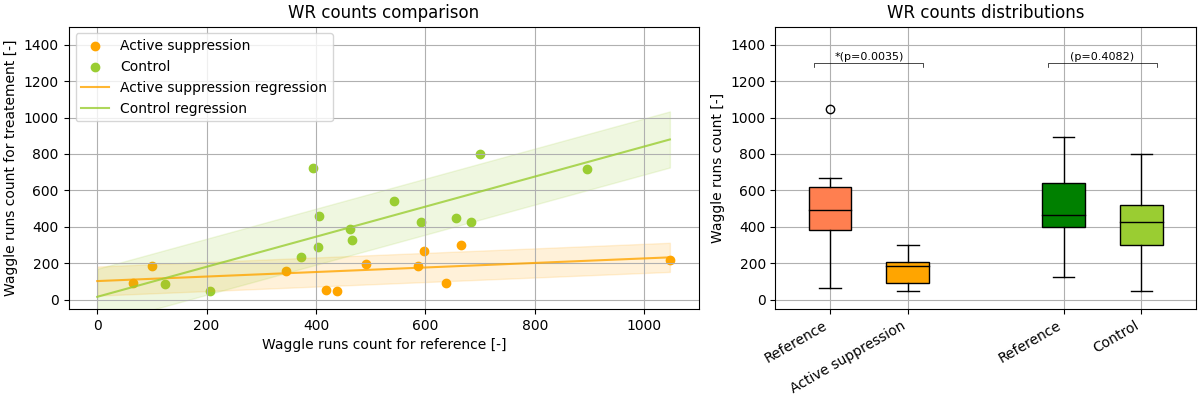

In [22]:
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(12,4), width_ratios=[60, 40], constrained_layout=True)

COLOR_REFERENCE_CONTROL = 'green'
COLOR_CONTROL           = 'yellowgreen'
COLOR_REFERENCE_VIBS    = 'coral'
COLOR_VIBS              = 'orange'

_ = ax[0].scatter(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, c=COLOR_VIBS, label='Active suppression')
_ = ax[0].scatter(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, c=COLOR_CONTROL, label='Control')

# Regression lines
coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, 1, full=True)
# source : chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.colorado.edu/amath/sites/default/files/attached-files/ch12_0.pdf
std_exp     = math.sqrt(res_exp/(len(results_2h[results_2h.type == 'exp'].Tcount_ctrl)-2))
std_blank   = math.sqrt(res_blank/(len(results_2h[results_2h.type == 'blank'].Tcount_ctrl)-2))
x_lines = range(max(results_2h.Tcount_ctrl.max(), results_2h.Tcount_vibs.max()))
y_exp   = coeffs_exp[0]*x_lines+coeffs_exp[1]
y_blank = coeffs_blank[0]*x_lines+coeffs_blank[1]
_ = ax[0].plot(x_lines, y_exp, c=COLOR_VIBS, label='Active suppression regression', alpha=0.8)
_ = ax[0].plot(x_lines, y_blank, c=COLOR_CONTROL, label='Control regression', alpha=0.8)
_ = ax[0].fill_between(x_lines, y_exp-std_exp, y_exp+std_exp, color=COLOR_VIBS, alpha=0.15)#, label='Active suppression STD regression')
_ = ax[0].fill_between(x_lines, y_blank-std_blank, y_blank+std_blank, color=COLOR_CONTROL, alpha=0.15)#, label='Control STD regression')

bplot = ax[1].boxplot([results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs], positions=[1, 2], widths=[0.55, 0.55], labels=['Reference', 'Suppression'], patch_artist=True, medianprops=dict(color='black'))
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_VIBS)
bplot['boxes'][1].set_facecolor(COLOR_VIBS)
bplot = ax[1].boxplot([results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs], positions=[4, 5], widths=[0.55, 0.55], labels=['Reference', 'Control'], patch_artist=True, medianprops=dict(color='black'))
bplot['boxes'][0].set_facecolor(COLOR_REFERENCE_CONTROL)
bplot['boxes'][1].set_facecolor(COLOR_CONTROL)

# Titles 
_ = ax[0].title.set_text('WR counts comparison')

RStest_exp = scipy.stats.ranksums(results_2h[results_2h.type=='exp'].Tcount_ctrl, results_2h[results_2h.type=='exp'].Tcount_vibs)
RStest_ctl = scipy.stats.ranksums(results_2h[results_2h.type=='blank'].Tcount_ctrl, results_2h[results_2h.type=='blank'].Tcount_vibs)
RStest_drop = scipy.stats.ranksums(distribution_dropT_ctrl, distribution_dropT_vibs)

_ = ax[1].title.set_text('WR counts distributions')


# Axis names
_ = ax[0].set_xlabel('Waggle runs count for reference [-]')
_ = ax[0].set_ylabel('Waggle runs count for treatement [-]')

_ = ax[1].set_ylabel('Waggle runs count [-]')

# ticks
_ = ax[1].set_xticklabels(['Reference', 'Active suppression', 'Reference', 'Control'], rotation=30, ha='right')

# Axis limits
YLIM_WR     = [-50, 1500]
YLIM_VAR    = [0, 2]
_ = ax[0].set_ylim(YLIM_WR)
_ = ax[1].set_ylim(YLIM_WR)

# _ = ax[0,0].set_aspect('equal')
XLIM_TYPE1 = [0.3, 5.7]
XLIM_TYPE2 = [0.5, 2.5]
_ = ax[1].set_xlim(XLIM_TYPE1)

# Legends
_ = ax[0].legend(loc='upper left')

# Grids
_ = ax[0].grid()
_ = ax[1].grid()

# Significance bars
sb_level    = 1300
sb_width    = 1.4
sb_height   = 20
sb_positions= [1.5, 4.5]
_ = ax[1].plot([sb_positions[0]-sb_width/2, sb_positions[0]-sb_width/2, sb_positions[0]+sb_width/2, sb_positions[0]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1].plot([sb_positions[1]-sb_width/2, sb_positions[1]-sb_width/2, sb_positions[1]+sb_width/2, sb_positions[1]+sb_width/2], [sb_level-sb_height, sb_level, sb_level, sb_level-sb_height], 'k', linewidth=.5)
_ = ax[1].text(sb_positions[0], sb_level+15, '*(p={:1.4f})'.format(RStest_exp[1]), fontsize=8, horizontalalignment='center')
_ = ax[1].text(sb_positions[1], sb_level+15, '(p={:1.4f})'.format(RStest_ctl[1]), fontsize=8, horizontalalignment='center')



In [23]:
samples_blank = list(numpy.array([list(results_2h[results_2h.type == 'blank'].Tcount_ctrl), list(results_2h[results_2h.type == 'blank'].Tcount_vibs)]).T)
SE_model_blank = numpy.array([(y-coeffs_blank[0]*x+coeffs_blank[1])**2 for x, y in samples_blank])
SE_diag_blank  = numpy.array([(y-x)**2 for x, y in samples_blank])
print('SSR from model : {}, SSR from my calculation : {}'.format(res_blank[0], numpy.sum(SE_model_blank)))

samples_exp = list(numpy.array([list(results_2h[results_2h.type == 'exp'].Tcount_ctrl), list(results_2h[results_2h.type == 'exp'].Tcount_vibs)]).T)
SE_model_exp = numpy.array([(y-coeffs_exp[0]*x+coeffs_exp[1])**2 for x, y in samples_exp])
SE_diag_exp  = numpy.array([(y-x)**2 for x, y in samples_exp])
print('SSR from model : {}, SSR from my calculation : {}'.format(res_exp[0], numpy.sum(SE_model_exp)))

print(scipy.stats.ranksums(SE_model_blank, SE_diag_blank))
print(scipy.stats.ranksums(SE_model_exp, SE_diag_exp))

SSR from model : 284144.9725310148, SSR from my calculation : 298079.0979197488
SSR from model : 57622.21439593301, SSR from my calculation : 517607.30945182574
RanksumsResult(statistic=-1.5622211221922153, pvalue=0.11823590633805431)
RanksumsResult(statistic=-2.068447839382762, pvalue=0.038597930654553664)


In [24]:
SE_expmodel_onexp = numpy.array([(y-coeffs_exp[0]*x+coeffs_exp[1])**2 for x, y in samples_exp])
SE_blankmodel_onblank = numpy.array([(y-coeffs_blank[0]*x+coeffs_blank[1])**2 for x, y in samples_blank])

SE_expmodel_onblank = numpy.array([(y-coeffs_exp[0]*x+coeffs_exp[1])**2 for x, y in samples_blank])
SE_blankmodel_onexp = numpy.array([(y-coeffs_blank[0]*x+coeffs_blank[1])**2 for x, y in samples_exp])

print(scipy.stats.ranksums(SE_expmodel_onblank, SE_expmodel_onexp))
print(scipy.stats.ranksums(SE_blankmodel_onblank, SE_blankmodel_onexp))

print(scipy.stats.ks_2samp(SE_expmodel_onblank, SE_expmodel_onexp))
print(scipy.stats.ks_2samp(SE_blankmodel_onblank, SE_blankmodel_onexp))

# from https://www.amstatisticalconsulting.com/one-way-ancova/
# and https://www.geeksforgeeks.org/how-to-perform-an-ancova-in-python/ 
from pingouin import ancova
# ancova(data=res_df_relative, dv='relative_fft_val', covar='water_config_id', between='actuator')
ancova(data=results_2h, dv='Tcount_vibs', covar='Tcount_ctrl', between='type')

RanksumsResult(statistic=3.2299485185630177, pvalue=0.0012381251019780227)
RanksumsResult(statistic=-2.8467342875470663, pvalue=0.004417021335680977)
KstestResult(statistic=0.7857142857142857, pvalue=0.00025710055189123704, statistic_location=102010.77942245982, statistic_sign=-1)
KstestResult(statistic=0.6233766233766234, pvalue=0.009391573563063669, statistic_location=11775.987990595568, statistic_sign=1)


,Source,SS,DF,F,p-unc,np2
0,type,411144.805105,1,18.247897,0.000311,0.453388
1,Tcount_ctrl,225787.306930,1,10.021149,0.004480,0.312954
2,Residual,495683.732031,22,NaN,NaN,NaN


In [25]:
import statsmodels.api as sm

coeffs_exp, res_exp, _, _, _        = numpy.polyfit(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs, 1, full=True)
coeffs_blank, res_blank, _, _, _    = numpy.polyfit(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs, 1, full=True)

res_exp     = scipy.stats.linregress(results_2h[results_2h.type == 'exp'].Tcount_ctrl, results_2h[results_2h.type == 'exp'].Tcount_vibs)
res_blank   = scipy.stats.linregress(results_2h[results_2h.type == 'blank'].Tcount_ctrl, results_2h[results_2h.type == 'blank'].Tcount_vibs)

In [26]:
coeffs_exp

array([  0.12440623, 102.2458151 ])

In [27]:
res_exp

LinregressResult(slope=0.12440623311361113, intercept=102.24581510172314, rvalue=0.4084773206470813, pvalue=0.21229830712286843, stderr=0.09266453829755952, intercept_stderr=51.46169239640508)